# Training a weather prediction model with a few more variables

* Other data as inputs (pressure, wind speed etc)
* Encode time as input (e.g. hour of day)
* Wind speed and direction as vector (snazzy!)

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor
from sklearn.model_selection import train_test_split
from numpy.lib.stride_tricks import sliding_window_view
import matplotlib.pyplot as plt

cursor = connect(s3_staging_dir="s3://dantelore.queryresults/pyathena/",
                 region_name="eu-west-1", cursor_class=PandasCursor).cursor()

length = 48
csv_data_cache_filename = "data/weather_models/raw_data_2.csv"
validation_site_name = 'WITTERING'

# Load the data from disk or Athena
if Path(csv_data_cache_filename).is_file():
    print("Loading weather data from cache")
    df = pd.read_csv(csv_data_cache_filename)
else:
    df = cursor.execute(f"select site_name, observation_ts, temperature, pressure, wind_speed, wind_direction from lake.weather order by site_name, observation_ts").as_pandas()
    df.to_csv(csv_data_cache_filename, index=False)

# Drop nulls
df = df.dropna()

# Normalise numeric fields
temperature_offset = df['temperature'].mean()
temperature_scale = df['temperature'].std()
print(f"Offset (mean temp): {temperature_offset}, Scale (stdev temp): {temperature_scale}")
df['temperature'] = df['temperature'].apply(lambda x: (x - temperature_offset) / temperature_scale)     

pressure_offset = df['pressure'].mean()
pressure_scale = df['pressure'].std()
print(f"Offset (mean pressure): {pressure_offset}, Scale (stdev pressure): {pressure_scale}")
df['pressure'] = df['pressure'].apply(lambda x: (x - pressure_offset) / pressure_scale)     

df



Loading weather data from cache
Offset (mean temp): 10.273621344002738, Scale (stdev temp): 5.573310157238021
Offset (mean pressure): 1013.9175258343165, Scale (stdev pressure): 12.165914294106491


,site_name,observation_ts,temperature,pressure,wind_speed,wind_direction
0,ABERDARON,2021-12-12 21:00:00,0.076504,-0.075418,37.0,S
1,ABERDARON,2021-12-12 22:00:00,0.112389,-0.075418,34.0,SSW
2,ABERDARON,2021-12-12 23:00:00,0.148274,0.006779,32.0,SW
3,ABERDARON,2021-12-13 00:00:00,-0.031152,0.088976,28.0,WSW
4,ABERDARON,2021-12-13 01:00:00,-0.049095,0.171173,25.0,WSW
...,...,...,...,...,...,...
1293908,YEOVILTON,2023-01-25 19:00:00,-1.125654,1.239732,1.0,W
1293909,YEOVILTON,2023-01-25 20:00:00,-1.125654,1.239732,3.0,N
1293910,YEOVILTON,2023-01-25 21:00:00,-0.964171,1.239732,6.0,NW
1293911,YEOVILTON,2023-01-25 22:00:00,-0.874457,1.321929,11.0,N


# Feature Engineering

## Encoding the time and date

Time of day is a bit of a sawtooth function, with 23:00 and 00:00 appearing to be much further appart than they are.  Use a cosine to fix this.  Actually, -cos, see below for details.

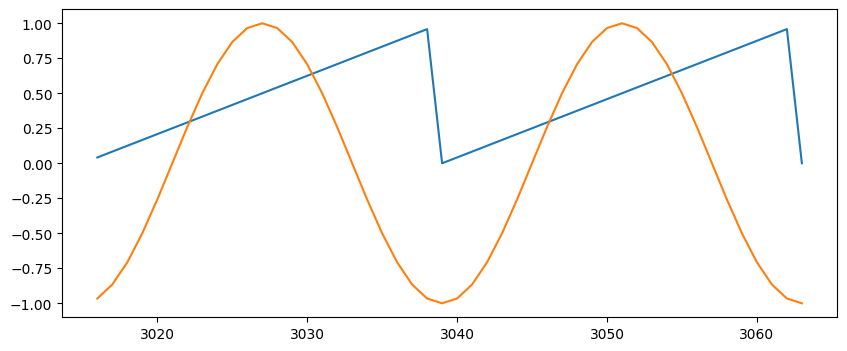

In [2]:
df['observation_ts'] = pd.to_datetime(df['observation_ts'], infer_datetime_format=True)
df['hour'] = df['observation_ts'].dt.hour
df['day_of_year'] = df['observation_ts'].dt.day_of_year

df['hour_cos'] = df['hour'].apply(lambda x: -np.cos(x / 24 * 2 * np.pi))

df['day_of_year_cos'] = df['day_of_year'].apply(lambda x: -np.cos(x / 365 * 2 * np.pi))

df_chart = df[3000:3048]
plt.figure(figsize=(10, 4))
plt.plot(df_chart['hour'].apply(lambda x: x / 24))
plt.plot(df_chart['hour_cos'])
plt.show()

Knowing a bit about how temperature goes up and down through a year and a day, it makes sense to use -cosine for hour_of_day, as the peaks align better.  Same for day of the year (year starts cold, gets warm, then cold again).

It's not a perfect correlation by any means.  The air temp will rise and fall at different times of day, depending on season and all sorts of other factors. But it is close, and it will certainly help the model.

You can see the correlation of the different functions in the corelation matrix, with the highest magnitude correlation with temp being -0.22.  It's not perfect by any means.  But like I say, it is close, and it will certainly help the model.

<AxesSubplot: >

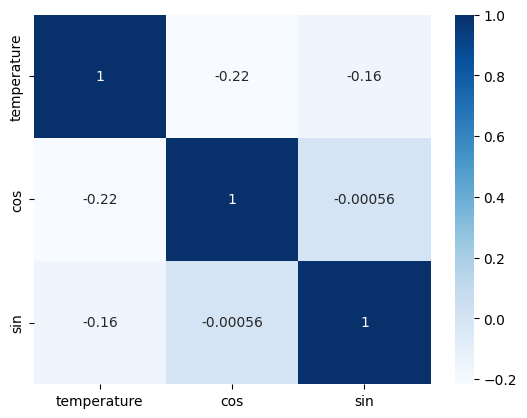

In [3]:
import seaborn as sb

df_chart = df[['hour', 'temperature']].copy()

df_chart['cos'] = df_chart['hour'].apply(lambda x: np.cos(x / 24 * 2 * np.pi))
df_chart['sin'] = df_chart['hour'].apply(lambda x: np.sin(x / 24 * 2 * np.pi))

correlation = df_chart[['temperature', 'cos', 'sin']].corr()
sb.heatmap(correlation, cmap="Blues", annot=True)

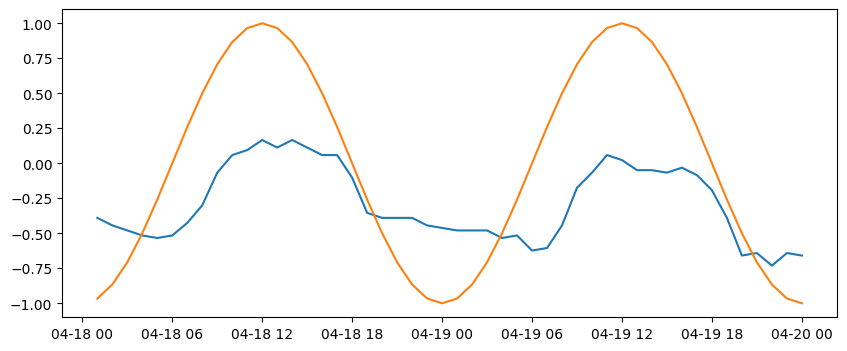

In [4]:
df_chart = df[3000:3048]
plt.figure(figsize=(10, 4))
plt.plot(df_chart['observation_ts'], df_chart['temperature'])
plt.plot(df_chart['observation_ts'], df_chart['hour_cos'])
plt.show()

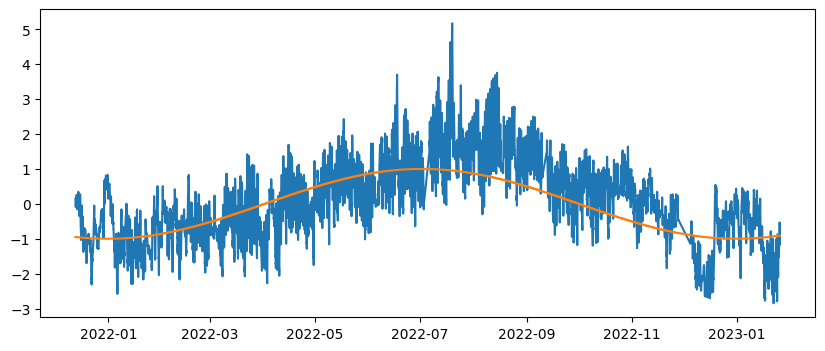

In [5]:
df_chart = df[df['site_name'].eq(validation_site_name)]
plt.figure(figsize=(10, 4))
plt.plot(df_chart['observation_ts'], df_chart['temperature'])
plt.plot(df_chart['observation_ts'], df_chart['day_of_year_cos'])
plt.show()

If you were wondering how well these two time variables work as a predictor for temperature... the answer is... kinda good, kinda bad...

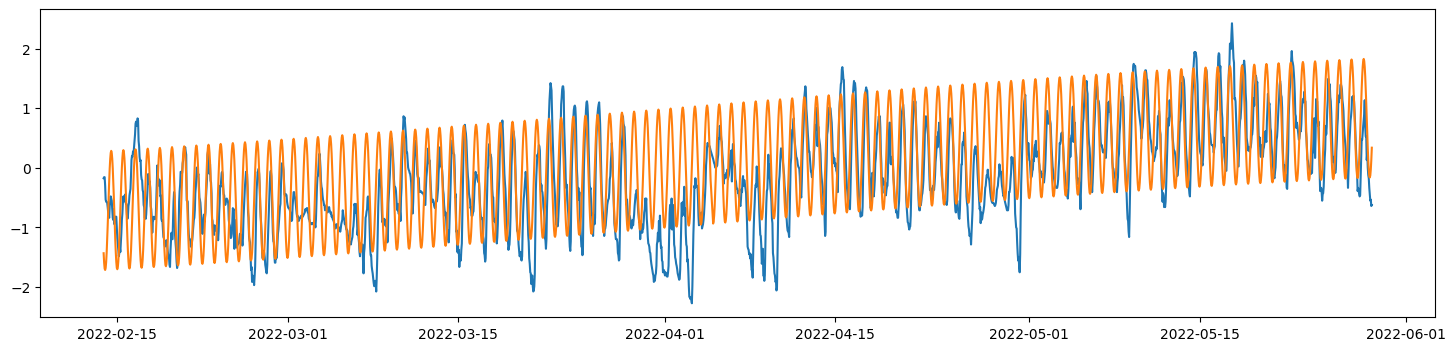

In [6]:
df_chart = df[df['site_name'].eq(validation_site_name)][1500:4000]
plt.figure(figsize=(18, 4))
plt.plot(df_chart['observation_ts'], df_chart['temperature'])
plt.plot(df_chart['observation_ts'], df_chart['day_of_year_cos']+ df_chart['hour_cos'])
plt.show()

## Wind speed and direction

Let's go from a string and a value to a vector in 2D space.

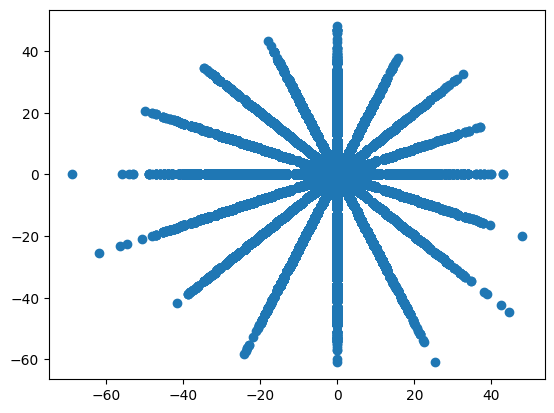

In [7]:
# First convert the nasty text to a compass point

wind_lookup = {
    "N": 0.0,
    "NNE": 22.5,
    "NE": 45.0,
    "ENE": 67.5,
    "E": 90.0,
    "ESE": 112.5,
    "SE": 135.0,
    "SSE": 157.5,
    "S": 180.0,
    "SSW": 202.5,
    "SW": 225.0,
    "WSW": 247.5,
    "W": 270.0,
    "WNW": 292.5,
    "NW": 315.0,
    "NNW": 337.5,
    "": 0.0,
    None: 0.0
}

df['wind_direction_degrees'] = df['wind_direction'].map(wind_lookup)

# Next convert to an X,Y coordinate, using direction and magnitude (wind speed)
def get_x(angle, magnitude):
    return np.cos(angle * np.pi / 180) * magnitude

def get_y(angle, magnitude):
    return np.sin(angle * np.pi / 180) * magnitude

df['wind_vector_x'] = df[['wind_direction_degrees', 'wind_speed']].apply(lambda v: get_x(*v), axis=1)
df['wind_vector_y'] = df[['wind_direction_degrees', 'wind_speed']].apply(lambda v: get_y(*v), axis=1)

# And plot the results...
plt.scatter(df['wind_vector_x'], df['wind_vector_y'])

# Prepare data for training

In [8]:
df = df[['site_name', 'observation_ts', 'temperature', 'pressure', 'wind_vector_x', 'wind_vector_y', 'hour_cos', 'day_of_year_cos']]

# Convert all the numbers to float32 for tensorflow
for col in ['temperature', 'pressure', 'wind_vector_x', 'wind_vector_y', 'hour_cos', 'day_of_year_cos']:
    df[col] = df[col].astype('float32')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1180697 entries, 0 to 1293912
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   site_name        1180697 non-null  object        
 1   observation_ts   1180697 non-null  datetime64[ns]
 2   temperature      1180697 non-null  float32       
 3   pressure         1180697 non-null  float32       
 4   wind_vector_x    1180697 non-null  float32       
 5   wind_vector_y    1180697 non-null  float32       
 6   hour_cos         1180697 non-null  float32       
 7   day_of_year_cos  1180697 non-null  float32       
dtypes: datetime64[ns](1), float32(6), object(1)
memory usage: 54.0+ MB


/var/folders/rb/9hrlfvs957q0mjt461wvmvzw0000gn/T/ipykernel_70428/2999997091.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype('float32')


In [9]:
# This chunk of code is just here to explain the sliding window function, and use of reshape etc.

i, j = np.ogrid[:10, :4]
x = 10*i + j
print(x.shape)
print(x)

v = sliding_window_view(x, (3,4), axis=(0,1))
v = v.reshape((v.shape[0], v.shape[2], v.shape[3]))
print(v.shape)
print(v)

(10, 4)
[[ 0  1  2  3]
 [10 11 12 13]
 [20 21 22 23]
 [30 31 32 33]
 [40 41 42 43]
 [50 51 52 53]
 [60 61 62 63]
 [70 71 72 73]
 [80 81 82 83]
 [90 91 92 93]]
(8, 3, 4)
[[[ 0  1  2  3]
  [10 11 12 13]
  [20 21 22 23]]

 [[10 11 12 13]
  [20 21 22 23]
  [30 31 32 33]]

 [[20 21 22 23]
  [30 31 32 33]
  [40 41 42 43]]

 [[30 31 32 33]
  [40 41 42 43]
  [50 51 52 53]]

 [[40 41 42 43]
  [50 51 52 53]
  [60 61 62 63]]

 [[50 51 52 53]
  [60 61 62 63]
  [70 71 72 73]]

 [[60 61 62 63]
  [70 71 72 73]
  [80 81 82 83]]

 [[70 71 72 73]
  [80 81 82 83]
  [90 91 92 93]]]


In [10]:
fields = ['temperature', 'pressure', 'wind_vector_x', 'wind_vector_y', 'hour_cos', 'day_of_year_cos']
field_count = len(fields)

input_sequences = np.empty([0, length, 6])
# Window the data
for site_name, readings in df.groupby('site_name'):
    if site_name != validation_site_name:
        values = readings[fields].to_numpy()

        # If ever a bit of code needed a unit tests, this is it.
        v = sliding_window_view(values, window_shape=(length, field_count), axis=(0, 1))
        windows = v.reshape((v.shape[0], v.shape[2], v.shape[3]))

        input_sequences = np.append(windows, input_sequences, axis=0)

        print(f"Window shape site {site_name}: {windows.shape}")

print(f"Combined data shape: {input_sequences.shape}")

# Some funky numpy slicing here.  We are slicing by axis in a 3D array - so xs takes all but the last item on the 2nd axis, ys takes only the last
xs = input_sequences[:,:-1]
ys = input_sequences[:,-1]

# There is no point trying to predict the time at the next timestep!  Drop time fields from the target
ys = np.delete(ys, [-2, -1], axis=1)

x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.05, shuffle=False)

# ((?, 23, 6), (?, 6), (?, 23, 6), (?, 6))
print(f"x_train: {x_train.shape} y_train: {y_train.shape} x_test: {x_test.shape} y_test: {y_test.shape}")

Window shape site ABERDARON: (8823, 24, 6)
Window shape site ABERDEEN AIRPORT: (8742, 24, 6)
Window shape site ABERPORTH: (9493, 24, 6)
Window shape site ABOYNE: (9484, 24, 6)
Window shape site ALBEMARLE: (9506, 24, 6)
Window shape site ALTNAHARRA SAWS: (9456, 24, 6)
Window shape site ANDREWSFIELD: (9422, 24, 6)
Window shape site AULTBEA: (9543, 24, 6)
Window shape site AVIEMORE: (9391, 24, 6)
Window shape site BALLYPATRICK FOREST: (9550, 24, 6)
Window shape site BALTASOUND: (9466, 24, 6)
Window shape site BEDFORD: (9550, 24, 6)
Window shape site BELFAST INTERNATIONAL AIRPORT: (9568, 24, 6)
Window shape site BELMULLET: (9581, 24, 6)
Window shape site BENSON: (9339, 24, 6)
Window shape site BINGLEY SAMOS: (9547, 24, 6)
Window shape site BOSCOMBE DOWN: (9523, 24, 6)
Window shape site BOULMER: (9010, 24, 6)
Window shape site BOURNEMOUTH AIRPORT: (9284, 24, 6)
Window shape site BRIDLINGTON MRSC: (9540, 24, 6)
Window shape site BRIZE NORTON: (9558, 24, 6)
Window shape site CAMBORNE: (9589, 

# Model Definition

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, InputLayer
from tensorflow.keras.optimizers import Adam

model = Sequential([
    InputLayer((length - 1, 6)), # Input shape here - time steps, features.  We have length-1 steps here, each with 6 features
    LSTM(length * 3),
    Dense(units=24, activation='relu'),
    Dense(units=4, activation='linear')
])

adam = Adam(lr=0.001)

model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=adam, metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Create the training history dataframe at the same time as the model...
history_df = pd.DataFrame(columns=['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

model.summary()

2023-01-27 11:59:16.415503: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-27 11:59:16.415617: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18176     
                                                                 
 dense (Dense)               (None, 24)                1560      
                                                                 
 dense_1 (Dense)             (None, 4)                 100       
                                                                 
Total params: 19,836
Trainable params: 19,836
Non-trainable params: 0
_________________________________________________________________


/Users/dan/Development/simple-prediction/.venv/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Training

Starting Run 0/1
Epoch 1/10


1110/1110 - 23s - loss: 4.7109 - mean_absolute_error: 1.1174 - val_loss: 5.7874 - val_mean_absolute_error: 1.2223 - 23s/epoch - 21ms/step
Epoch 2/10


1110/1110 - 23s - loss: 4.7108 - mean_absolute_error: 1.1177 - val_loss: 5.7806 - val_mean_absolute_error: 1.2207 - 23s/epoch - 21ms/step
Epoch 3/10


1110/1110 - 23s - loss: 4.6935 - mean_absolute_error: 1.1160 - val_loss: 5.7599 - val_mean_absolute_error: 1.2152 - 23s/epoch - 21ms/step
Epoch 4/10
1110/1110 - 19s - loss: 4.6871 - mean_absolute_error: 1.1155 - val_loss: 5.7678 - val_mean_absolute_error: 1.2194 - 19s/epoch - 17ms/step
Epoch 5/10


1110/1110 - 23s - loss: 4.6796 - mean_absolute_error: 1.1149 - val_loss: 5.7572 - val_mean_absolute_error: 1.2177 - 23s/epoch - 21ms/step
Epoch 6/10


1110/1110 - 23s - loss: 4.6720 - mean_absolute_error: 1.1140 - val_loss: 5.7439 - val_mean_absolute_error: 1.2166 - 23s/epoch - 21ms/step
Epoch 7/10


1110/1110 - 24s - loss: 4.6651 - mean_absolute_error: 1.1133 - val_loss: 5.7355 - val_mean_absolute_error: 1.2148 - 24s/epoch - 21ms/step
Epoch 8/10
1110/1110 - 20s - loss: 4.6592 - mean_absolute_error: 1.1129 - val_loss: 5.7410 - val_mean_absolute_error: 1.2164 - 20s/epoch - 18ms/step
Epoch 9/10


1110/1110 - 23s - loss: 4.6538 - mean_absolute_error: 1.1127 - val_loss: 5.7353 - val_mean_absolute_error: 1.2134 - 23s/epoch - 21ms/step
Epoch 10/10
1110/1110 - 20s - loss: 4.6456 - mean_absolute_error: 1.1118 - val_loss: 5.7358 - val_mean_absolute_error: 1.2146 - 20s/epoch - 18ms/step


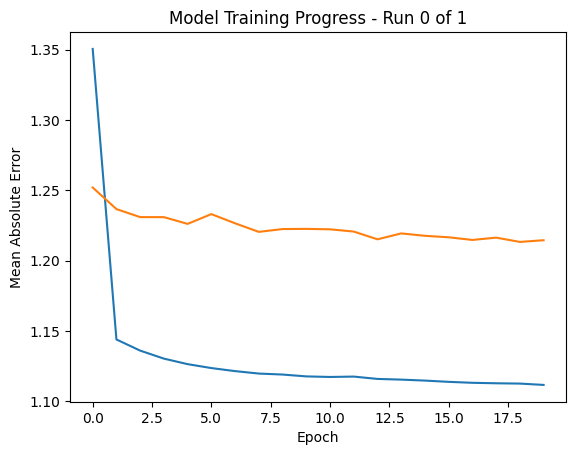

In [15]:
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.callbacks import ModelCheckpoint

tf.get_logger().setLevel('ERROR')

run_count = 1
epochs_per_run = 10
model_filename = 'data/weather_models/model2/'

cp = ModelCheckpoint(model_filename, save_best_only=True, verbose=0)

for run in range(0, run_count):
    print(f"Starting Run {run}/{run_count}")
    # Use verbose=2 here to prevent progreess bars locking up jupyter after a few hours
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs_per_run, verbose=2, callbacks=[cp], batch_size=1000)

    history_df = pd.concat([history_df, pd.DataFrame(history.history)], ignore_index=True)

    plt.plot(history_df['mean_absolute_error'], label="Training Error")
    plt.plot(history_df['val_mean_absolute_error'], label="Validation Error")
    plt.title(f'Model Training Progress - Run {run} of {run_count}')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.show()

# Results/Performance

6/6 [==============================] - 0s 7ms/step


,predicted_temperature,predicted_pressure,predicted_wind_vector_x,predicted_wind_vector_y,actual_temperature,actual_pressure,actual_wind_vector_x,actual_wind_vector_y,actual_hour_cos,actual_day_of_year_cos
0,-1.966690,-0.795770,-0.203308,-8.431200,-2.076615,-0.815190,-2.020667e-15,-11.000000,-1.000000e+00,-0.946988
1,-1.997170,-0.782903,-0.452884,-9.584970,-2.094558,-0.815190,-3.444151e+00,-8.314916,-9.659258e-01,-0.946988
2,-2.029154,-0.757549,-2.200036,-8.951409,-2.148386,-0.815190,-1.653273e-15,-9.000000,-8.660254e-01,-0.946988
3,-2.077433,-0.758746,-1.291327,-8.767802,-2.291927,-0.732993,-2.020667e-15,-11.000000,-7.071068e-01,-0.946988
4,-2.167603,-0.698225,-0.707140,-9.440465,-2.238099,-0.815190,-3.061467e+00,-7.391036,-5.000000e-01,-0.946988
...,...,...,...,...,...,...,...,...,...,...
162,-0.925606,1.051739,-3.447079,-8.119186,-0.533547,1.075338,7.071068e+00,-7.071068,1.836970e-16,-0.908818
163,-0.692095,1.106929,6.506480,-6.721063,-0.766801,1.157535,4.949748e+00,-4.949748,-2.588190e-01,-0.908818
164,-0.945026,1.155750,5.720704,-4.871100,-0.802687,1.157535,7.778174e+00,-7.778174,-5.000000e-01,-0.908818
165,-0.915844,1.149574,7.271782,-6.127946,-0.928285,1.157535,1.016267e+01,-4.209518,-7.071068e-01,-0.908818


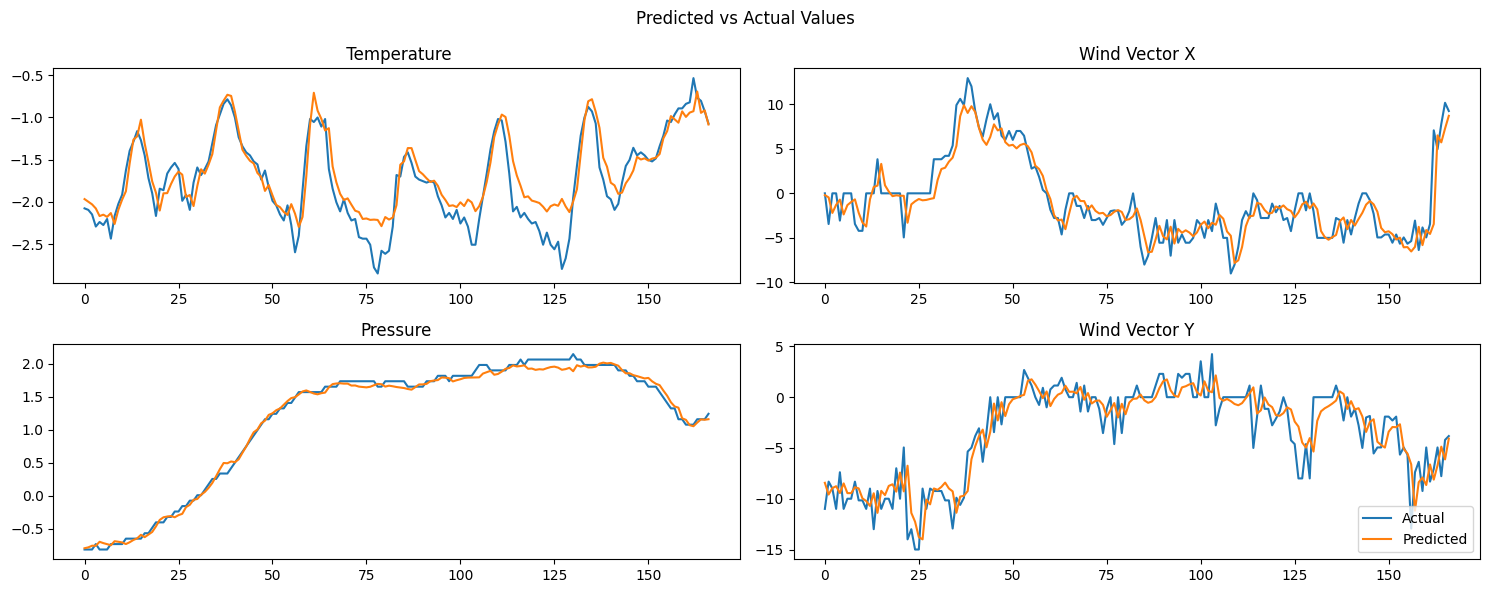

In [16]:
df_validate = df[df['site_name'].eq(validation_site_name)][fields]

values = df_validate.to_numpy()

v = sliding_window_view(values, window_shape=(length, field_count), axis=(0, 1))
windows = v.reshape((v.shape[0], v.shape[2], v.shape[3]))

l = 24 * 7 # Show 7 days on the chart
windows = windows[-l:-1]

model_inputs = windows[:,:-1]
actuals = windows[:,-1]

results = model.predict(model_inputs)
train_predictions = pd.DataFrame(results, columns=[f"predicted_{name}" for name in fields[:-2]])
train_actuals = pd.DataFrame(actuals, columns=[f"actual_{name}" for name in fields])

train_results = train_predictions.join(train_actuals)

#train_results['Predicted'] = train_results['Predicted'].apply(lambda x: x * scale + offset)
#train_results['Actual'] = train_results['Actual'].apply(lambda x: x * scale + offset)

fig, axs = plt.subplots(2, 2, figsize=(15, 6))
fig.suptitle('Predicted vs Actual Values')

axs[0,0].plot(train_results['actual_temperature'])
axs[0,0].plot(train_results['predicted_temperature'])
axs[0,0].set_title(f' Temperature')

axs[1,0].plot(train_results['actual_pressure'])
axs[1,0].plot(train_results['predicted_pressure'])
axs[1,0].set_title(f'Pressure')

axs[0,1].plot(train_results['actual_wind_vector_x'])
axs[0,1].plot(train_results['predicted_wind_vector_x'])
axs[0,1].set_title(f'Wind Vector X')

axs[1,1].plot(train_results['actual_wind_vector_y'], label="Actual")
axs[1,1].plot(train_results['predicted_wind_vector_y'], label="Predicted")
axs[1,1].set_title(f'Wind Vector Y')
axs[1,1].legend(loc="lower right")

fig.tight_layout()

train_results